In [3]:
import numpy as np
import os
import glob
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import warnings
from astropy.stats import circmean
%matplotlib inline
from astropy.convolution import convolve, convolve_fft
from skimage.morphology import disk
import random


c:\Users\Sophia\AppData\Local\anaconda3\envs\processing_pipeline\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df_path = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\cell_characteristics\spatial_features\spatial_data\directional_tuning_5_degrees_first5.csv"
df_path = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\cell_characteristics\spatial_features\spatial_data\directional_tuning_15_degrees_10000shifts.csv"
df = pd.read_csv(df_path)
df = df[df['significant'] == 'sig']
behaviour_path = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-01_date-02072025\task_metadata\behaviour.csv"
behaviour_df = pd.read_csv(behaviour_path, header = None)
behaviour_df

arms_dir = ["N", "NW", "SW", "S", "SE", "NE"]
arms_angles_start = [30, 90, 150, 210, 270, 330]
print(df)

      Unnamed: 0  cell  trial  epoch       MRL  mean_direction  percentiles95  \
9              9     0      4      1  0.443375     -108.704373       0.343823   
24            24     1      1      1  0.183943       56.508334       0.181835   
36            36     1      5      1  0.321451      155.013653       0.318392   
55            55     2      3      2  0.141807      -67.828635       0.108773   
61            61     2      5      2  0.168297       44.706324       0.147653   
...          ...   ...    ...    ...       ...             ...            ...   
6392        6392   338      1      1  0.130705       71.851399       0.118973   
6413        6413   338      8      1  0.453511      118.239135       0.363611   
6454        6454   340      6      1  0.320732      121.087730       0.273052   
6526        6526   343      6      1  0.185931       -4.290097       0.159908   
6528        6528   343      6      3  0.189444      -48.437410       0.171484   

      percentiles99 signifi

C:\Users\Sophia\AppData\Local\Temp\ipykernel_94952\3677496459.py:84: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


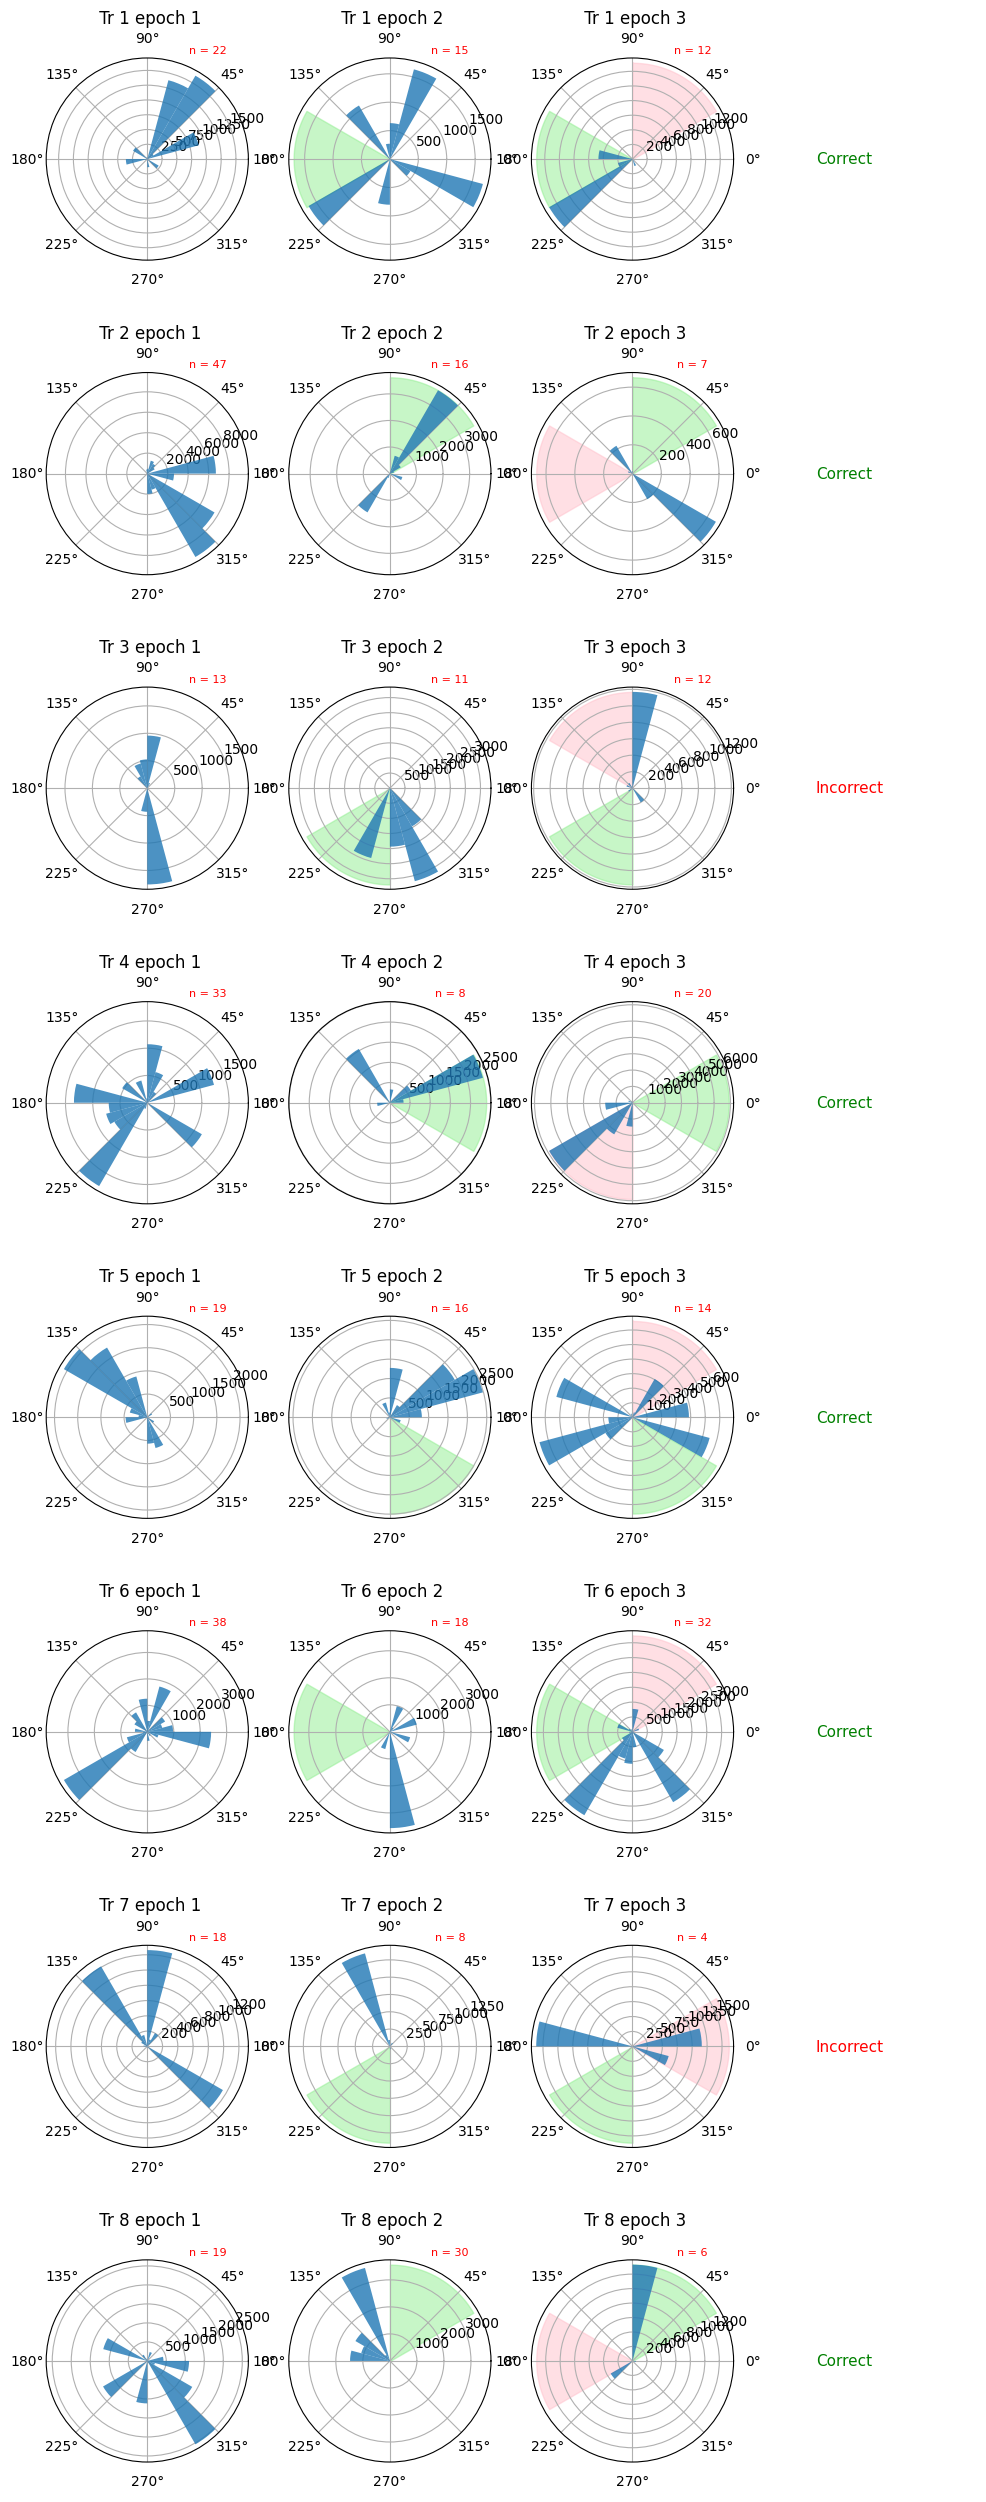

In [15]:
trials_to_include = np.arange(1,9)
num_bins = 24

fig, axs = plt.subplots(len(trials_to_include), 4, figsize = [3*4, 4*len(trials_to_include)], subplot_kw = {'projection': 'polar'})

for tr in trials_to_include:
    for e in np.arange(1,4):
        num_spikes_arr = []
        mean_dir_arr = []
        sum_count_bin = []

        filtered_df = df[(df['trial'] == tr) & (df['epoch'] == e)]

        if len(filtered_df) > 0:
            mean_dir_arr = np.array(filtered_df['mean_direction'])
            num_spikes_arr = np.array(filtered_df['num_spikes'])
            counts, bin_edges = np.histogram(mean_dir_arr, bins = num_bins, range = (-180, 180))

            bin_idx = np.digitize(mean_dir_arr, bin_edges) - 1 

            for i in range(len(bin_edges) - 1):
                indices = np.where(bin_idx == i)
                num_spikes_i = num_spikes_arr[indices]
                sum_count_bin.append(np.sum(num_spikes_i))

            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            
            bin_centers = np.deg2rad(bin_centers)
            width = np.diff(bin_centers)[0]

            axs[tr-1, e-1].bar(
                bin_centers,
                sum_count_bin,
                width=width,
                bottom=0.0,
                alpha=0.8,
                zorder = 2
            )

            axs[tr-1, e-1].text(
                np.pi/3,                # angle in radians
                1.25* np.nanmax(sum_count_bin),         # radius (just outside the bar)
                f"n = {len(filtered_df)}",   # label text
                ha='center',
                va='bottom',
                fontsize=8,
                rotation_mode='anchor',
                color = 'r',
            )

            if e > 1:
                arm = behaviour_df.iloc[tr-1, 1]
                index = np.where(np.array(arms_dir) == arm)[0][0]
                angle_start = arms_angles_start[index]
                theta = np.linspace(np.deg2rad(angle_start), np.deg2rad(angle_start + 60), 100) 
                r = np.ones_like(theta) * np.nanmax(sum_count_bin)
                axs[tr-1, e-1].fill_between(theta, 0, r, color='lightgreen', alpha=0.5, zorder=0)

            if e > 2:
                arm = behaviour_df.iloc[tr-1, 2]
                index = np.where(np.array(arms_dir) == arm)[0][0]
                angle_start = arms_angles_start[index]
                theta = np.linspace(np.deg2rad(angle_start), np.deg2rad(angle_start + 60), 100) 
                r = np.ones_like(theta) * np.nanmax(sum_count_bin)
                axs[tr-1, e-1].fill_between(theta, 0, r, color='pink', alpha=0.5, zorder=0)

        
        axs[tr-1, e-1].set_title(f" Tr {tr} epoch {e}")

    if behaviour_df.iloc[tr-1, 3] == "Y":
        text = "Correct"
        c = 'g'
    else:
        text = "Incorrect"
        c = 'r'

    axs[tr-1, 3].remove() 
    axs[tr-1, 3] = fig.add_subplot(len(trials_to_include), 5, (tr-1)*5 + 5) 
    axs[tr-1, 3].axis('off') 
    axs[tr-1, 3].text(0.0, 0.5, text, fontsize=11, va='center', ha='left', wrap=True, c= c)


plt.tight_layout()
plt.show()


In [60]:
num_spikes_arr

[]

25